# Survival Regression with `estimators.SurvivalModel`
<hr>

Author: ***Willa Potosnak***  &lt;wpotosna@andrew.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>

# Contents


### 1. [Introduction](#introduction) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.1 [The SUPPORT Dataset](#support)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.2 [Preprocessing the Data](#preprocess)

### 2. [Cox Proportional Hazards (CPH)](#cph) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.1 [Fit CPH Model](#fitcph)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.2 [Evaluate CPH Model](#evalcph)

### 3. [Deep Cox Proportional Hazards (DCPH)](#fsn) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 [Fit DCPH Model](#fitfsn)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.2 [Evaluate DCPH Model](#evalfsn)

### 4. [Deep Survival Machines (DSM)](#dsm) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.1 [Fit DSM Model](#fitdsm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.2 [Evaluate DSM Model](#evaldsm)

### 5. [Deep Cox Mixtures (DCM)](#dcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.1 [Fit DCM Model](#fitdcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.2 [Evaluate DCM Model](#evaldcm)

### 6. [Random Survival Forests (RSF)](#rsf)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   6.1 [Fit RSF Model](#fitrsf)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   6.2 [Evaluate RSF Model](#evalrsf)

<hr>

<a id="introduction"></a>

## 1. Introduction

The `SurvivalModels` class offers a steamlined approach to train two `auton-survival` models and three baseline survival models for right-censored time-to-event data. The fit method requires the same inputs across all five models, however, model parameter types vary and must be defined and tuned for the specified model.

### Native `auton-survival` Models

* **Faraggi-Simon Net (FSN)/DeepSurv**
* **Deep Survival Machines (DSM)** 
* **Deep Cox Mixtures (DCM)**

### External Models

* **Random survival Forests (RSF)**
* **Cox Proportional Hazards (CPH)**

 
$\textbf{Hyperparameter tuning}$ and $\textbf{model evaluation}$ can be performed using the following metrics, among others.

* $\textbf{Brier Score (BS)}$: the Mean Squared Error (MSE) around the probabilistic prediction at a certain time horizon. The Brier Score can be decomposed into components that measure both discriminative performance and calibration.

\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}

* $\textbf{Integrated Brier Score (IBS)}$: the integral of the time-dependent $\textbf{BS}$ over the interval $[t_1; t_{max}]$ where the weighting function is $w(t)= \frac{t}{t_{max}}$.

\begin{align}
\text{IBS} = \int_{t_1}^{t_{max}} \mathrm{BS}^{c}(t)dw(t)
\end{align}

* $\textbf{Area under ROC Curve (ROC-AUC)}$: survival model evaluation can be treated as binary classification to compute the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** dependent on time, $t$. ROC-AUC is used to assess how well the model can distinguish samples that fail by a given time, $t$ from those that fail after this time.

\begin{align}
\widehat{AUC}(t) = \frac{\sum_{i=1}^{n} \sum_{j=1}^{n}I(y_j>t)I(y_i \leq t)w_iI(\hat{f}(x_j) \leq \hat{f}(x_i))}{(\sum_{i=1}^{n} I(y_i > t))(\sum_{i=1}^{n}I(y_i \leq t)w_i)}
\end{align}

* $\textbf{Time Dependent Concordance Index (C$^{td}$)}$: estimates ranking ability by exhaustively comparing relative risks across all pairs of individuals in the test set. We employ the ‘Time Dependent’ variant of Concordance Index that truncates the pairwise comparisons to the events occurring within a fixed time horizon. 

\begin{align}
C^{td}(t) = P(\hat{F}(t|x_i) > \hat{F} (t|x_j)|\delta_i = 1, T_i < T_j, T_i \leq t)
\end{align}


<a id="support"></a>

### 1.1. The SUPPORT Dataset

*For the original datasource, please refer to the following [website](https://biostat.app.vumc.org/wiki/Main/SupportDesc).*

Data features $x$ are stored in a pandas dataframe with rows corresponding to individual samples and columns as covariates. Data outcome consists of 'time', $t$, and 'event', $e$, that correspond to the time to event and the censoring indicator, respectively. 

In [1]:
import pandas as pd
import sys
sys.path.append('../')

from auton_survival.datasets import load_dataset
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load the SUPPORT dataset
outcomes, features = load_dataset(dataset='SUPPORT')

# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Let's take a look at the features
display(features.head(5))

# Let's take a look at the outcomes
display(outcomes.head(5))

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


<a id="preprocess"></a>
### 1.2. Preprocess the Data

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 5463
Number of validation data points: 1821
Number of test data points: 1821


In [4]:
from auton_survival.preprocessing import Preprocessor

# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

<a id="cph"></a>
## 2. Cox Proportional Hazards (CPH) 

<b>CPH</b> [2]  model assumes that individuals across the population have constant proportional hazards overtime. In this model, the estimator of the survival function conditional on $X, S(·|X) , P(T > t|X)$, is assumed to have constant proportional hazard. Thus, the relative proportional hazard between individuals is constant across time.

*For full details on CPH, please refer to the following paper*:

[2] [Cox, D. R. (1972). Regression models and life-tables. Journal of the Royal Statistical Society: Series B (Methodological).](https://www.jstor.org/stable/2985181)

<a id="fitcph"></a>
### 2.1. Fit CPH Model


In [5]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'l2' : [1e-3, 1e-4]}
params = ParameterGrid(param_grid)

# Define the times for model evaluation
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('cph', random_seed=2, l2=param['l2'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

AssertionError: 

<a id="evalcph"></a>
### 2.2. Evaluate CPH Model


In [ ]:
# from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
# plot_performance_metrics(results, times)

<a id="fsn"></a>
## 3. Deep Cox Proportional Hazards (DCPH)

<b>DCPH</b> [2], [3] is an extension to the CPH model. DCPH involves modeling the proportional hazard ratios over the individuals with Deep Neural Networks allowing the ability to learn non linear hazard ratios.

*For full details on DCPH models, Faraggi-Simon Net (FSN) and DeepSurv, please refer to the following papers*:

[2] [Faraggi, David, and Richard Simon. "A neural network model for survival data." Statistics in medicine 14.1 (1995): 73-82.](https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.4780140108)

[3] [Katzman, Jared L., et al. "DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network." BMC medical research methodology 18.1 (2018): 1-12.](https://arxiv.org/abs/1606.00931v3)

<a id="fitfsn"></a>
### 3.1. Fit DCPH Model

In [17]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'bs' : [100, 200],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcph', random_seed=0, bs=param['bs'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

<a id="evalfsn"></a>
### 3.2. Evaluate DCPH Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="dsm"></a>
## 4. Deep Survival Machines (DSM)

<b>DSM</b> [5] is a fully parametric approach to modeling the event time distribution as a fixed size mixture over Weibull or Log-Normal distributions. The individual mixture distributions are parametrized with neural networks to learn complex non-linear representations of the data.

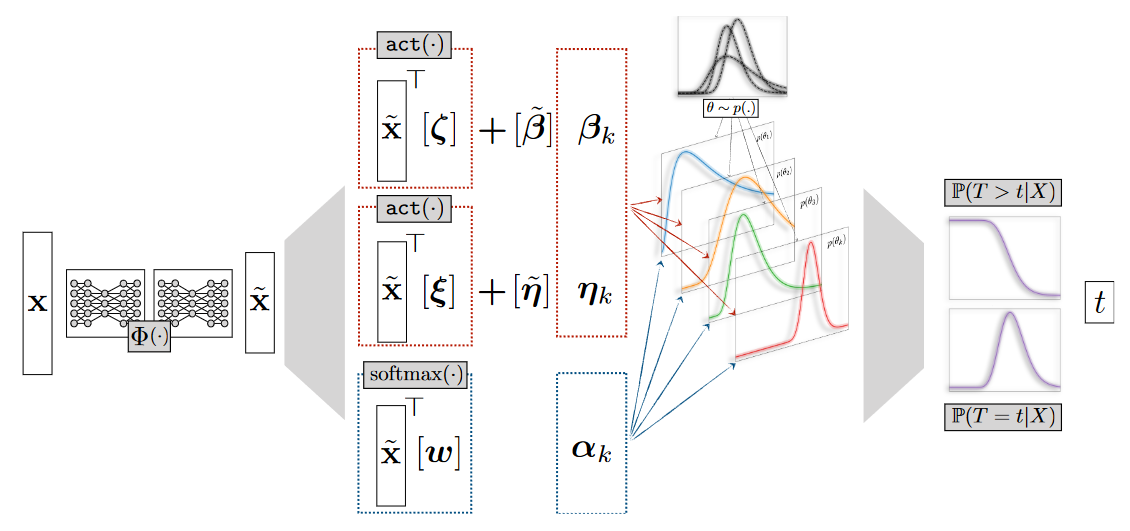


<b>Figure A:</b> DSM works by modeling the conditional distribution $P(T |X = x)$ as a mixture over $k$ well-defined, parametric distributions. DSM generates representation of the individual covariates, $x$, using a deep multilayer perceptron followed by a softmax over mixture size, $k$. This representation then interacts with the additional set of parameters,  to determine the mixture weights $w$ and the parameters of each of $k$ underlying survival distributions $\{\eta_k, \beta_k\}^K_{k=1}$. The final individual survival distribution for the event time, $T$, is a weighted average over these $K$ distributions.


*For full details on Deep Survival Machines (DSM), please refer to the following paper*:

[5] [Chirag Nagpal, Xinyu Li, and Artur Dubrawski. Deep survival machines: Fully parametric survival regression and representation learning for censored data with competing risks. 2020.](https://arxiv.org/abs/2003.01176)


<a id="fitdsm"></a>
### 4.1. Fit DSM Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'layers' : [[100], [100, 100], [200]],
              'distribution' : ['Weibull', 'LogNormal'],
              'max_features' : ['sqrt', 'log2']
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dsm', random_seed=0, layers=param['layers'], distribution=param['distribution'], max_features=param['max_features'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evaldsm"></a>
### 4.2. Evaluate DSM Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="dcm"></a>
## 5. Deep Cox Mixtures (DCM)

<b>DCM</b> [2] generalizes the proportional hazards assumption via a mixture model, by assuming that there are latent groups and within each, the proportional hazards assumption holds. DCM allows the hazard ratio in each latent group, as well as the latent group membership, to be flexibly modeled by a deep neural network.

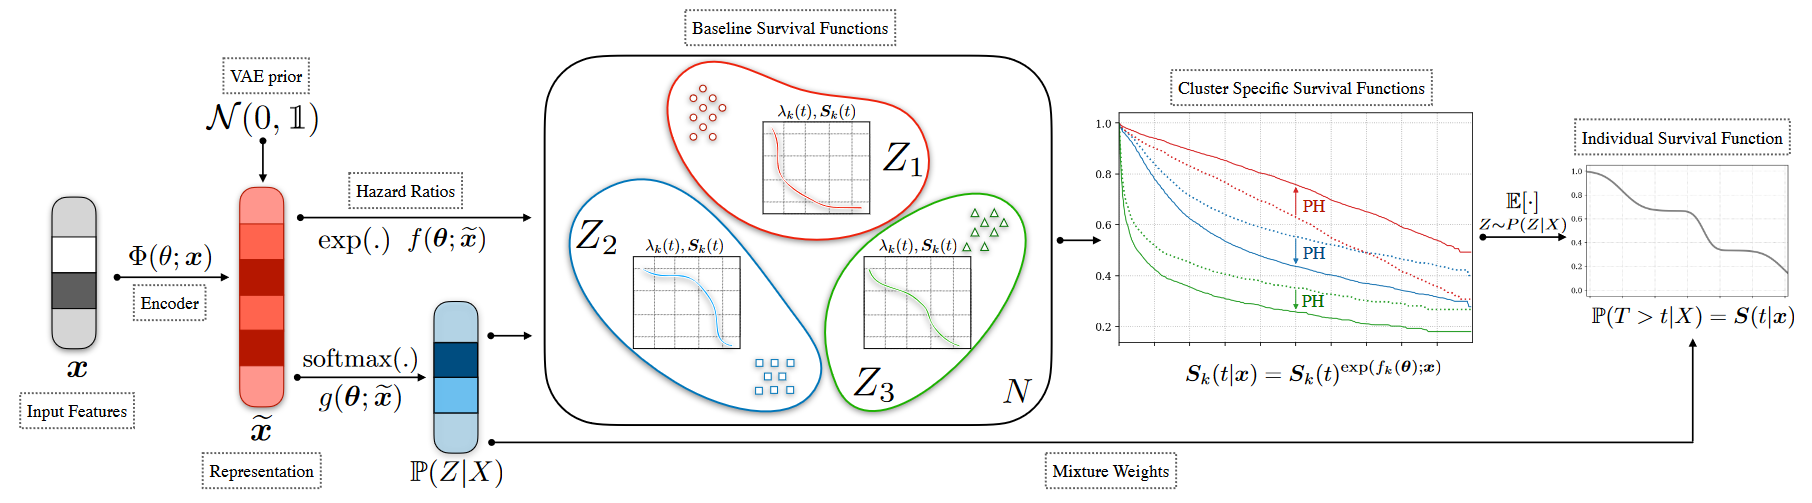

<b>Figure B:</b> DCM works by generating representation of the individual covariates, $x$, using an encoding neural network. The output representation, $xe$, then interacts with linear functions, $f$ and $g$, that determine the proportional hazards within each cluster $Z ∈ {1, 2, ...K}$ and the mixing weights $P(Z|X)$ respectively. For each cluster, baseline survival rates $Sk(t)$ are estimated non-parametrically. The final individual survival curve $S(t|x)$ is an average over the cluster specific individual survival curves weighted by the mixing probabilities $P(Z|X = x)$.


*For full details on Deep Cox Mixtures (DCM), please refer to the following paper*:

[2] [Nagpal, C., Yadlowsky, S., Rostamzadeh, N., and Heller, K. (2021c). Deep cox mixtures for survival regression. In
Machine Learning for Healthcare Conference, pages 674–708. PMLR.](https://arxiv.org/abs/2101.06536)

<a id="fitdcm"></a>
### 5.1. Fit DCM Model

In [21]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [1],
              'learning_rate' : [1e-4]
              # 'layers' : [[100], [100, 100]],
             }

alphas = [[0], [0.001], [0.1], [1], [10], [100], [1000]]
params = ParameterGrid(param_grid)
weights = []

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for alpha in alphas:
    for param in params:
        # model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'], alphas=alphas)
        model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'],layers=[] ,alphas=alpha)
        
        # The fit method is called to train the model
        model.fit(x_tr, y_tr)
    
        # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
        predictions_val = model.predict_survival(x_val, times)
        metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
        models.append([metric_val, model])
    weight = model._model.torch_model[0].expert.weight
    weights.append(weight)
    
print(weights)
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

age                           float64
num.co                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
pafi                          float64
alb                           float64
bili                          float64
crea                          float64
sod                           float64
ph                            float64
glucose                       float64
bun                           float64
urine                         float64
adlp                          float64
adls                          float64
sex_male                         bool
dzgroup_CHF                      bool
dzgroup_COPD                     bool
dzgroup_Cirrhosis                bool
dzgroup_Colon Cancer             bool
dzgroup_Coma                     bool
dzgroup_Lung Cancer              bool
dzgroup_MOSF w/Malig             bool
dzclass_COPD

 74%|███████▍  | 37/50 [00:05<00:01,  7.09it/s]

[Parameter containing:
tensor([[ 0.1082,  0.0130, -0.0156,  0.0027, -0.0261,  0.0581,  0.0364, -0.0065,
         -0.0268,  0.0870,  0.0396, -0.0582, -0.0450,  0.0344,  0.0525,  0.0096,
          0.0043,  0.1240,  0.0240, -0.0942, -0.0402,  0.0631,  0.0093,  0.1914,
          0.1884,  0.0487, -0.1852,  0.1393,  0.0810, -0.0732, -0.0079,  0.0376,
         -0.0460, -0.0837,  0.0794, -0.0471, -0.1841,  0.1709]],
       requires_grad=True), Parameter containing:
tensor([[ 0.1082,  0.0130, -0.0156,  0.0027, -0.0261,  0.0581,  0.0364, -0.0065,
         -0.0268,  0.0870,  0.0396, -0.0582, -0.0450,  0.0344,  0.0525,  0.0095,
          0.0043,  0.1240,  0.0240, -0.0942, -0.0402,  0.0630,  0.0093,  0.1914,
          0.1884,  0.0486, -0.1851,  0.1393,  0.0809, -0.0732, -0.0079,  0.0376,
         -0.0460, -0.0836,  0.0792, -0.0470, -0.1841,  0.1709]],
       requires_grad=True), Parameter containing:
tensor([[ 0.1076,  0.0132, -0.0157,  0.0035, -0.0249,  0.0571,  0.0356, -0.0064,
         -0.0258, 

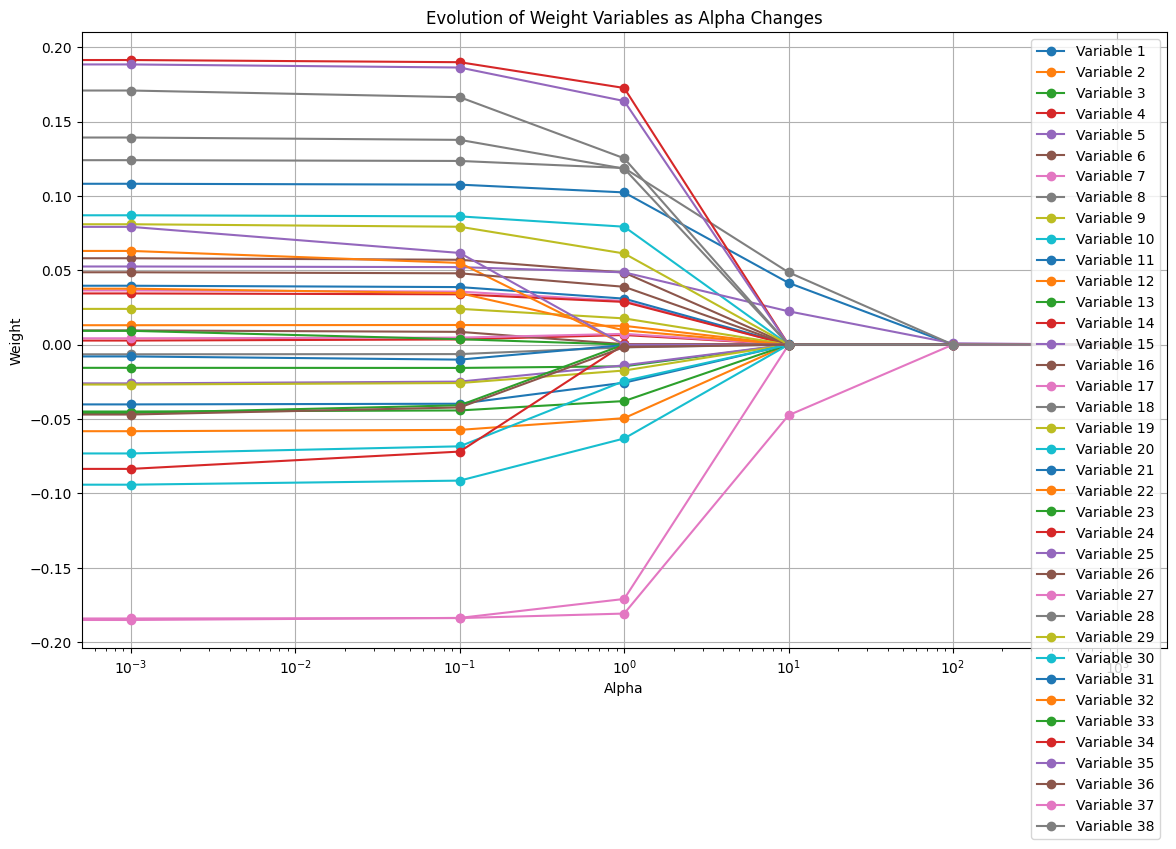

In [24]:
import matplotlib.pyplot as plt

flat_alphas = [alpha for sublist in alphas for alpha in sublist]

new_weights = []
for w in weights:
    new_weights.append(w.detach().numpy())

# Conversion de la liste de tableaux en un tableau NumPy
wxd = np.array(new_weights)  # Shape sera (nombre_de_alphas, 1, nombre_de_variables)

# Tracer chaque variable
plt.figure(figsize=(14, 8))
for i in range(wxd.shape[2]):  # weights.shape[2] est le nombre de variables
    plt.plot(alphas, wxd[:, 0, i], marker='o', label=f'Variable {i+1}')

plt.xscale('log')  # Échelle logarithmique pour les valeurs de alpha
plt.xlabel('Alpha')
plt.ylabel('Weight')
plt.title('Evolution of Weight Variables as Alpha Changes')
plt.legend()  # Ajoute une légende pour identifier chaque variable
plt.grid(True)  # Ajoute une grille pour une meilleure lisibilité
plt.show()

<a id="evaldcm"></a>
### 5.2. Evaluate DCM Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

In [ ]:
from auton_survival.metrics import survival_regression_metric

predictions_te = model.predict_survival(x_te, times)

#use sensitivity_score
predictions_te = np.array(predictions_te)
predictions_te = np.where(predictions_te > 0.5, 1, 0)
print(predictions_te)
sensitivity_score = survival_regression_metric('sblty', outcomes=y_te, predictions=predictions_te, times=times, outcomes_train=y_tr)

### SUPPORT

#### Cox - Cox L1

In [ ]:
#load support dataset
from auton_survival.datasets import load_dataset
outcomes, features = load_dataset(dataset='SUPPORT')

#combine the features and outcomes
data = pd.concat([features, outcomes], axis=1)
data

In [ ]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations = data['time'], event_observed = data['event'])
kmf.plot_survival_function()

In [ ]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
m = (data["sex"] == "male")
kmf.fit(durations = data['time'][m], event_observed = data['event'][m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(data['time'][~m], event_observed = data['event'][~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")

In [ ]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls','time', 'event']

In [ ]:
#preprocess the data
from auton_survival.preprocessing import Preprocessor
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
transformer = preprocessor.fit(data, cat_feats=cat_feats, num_feats=num_feats, one_hot=True, fill_value=-1)
x_tr = transformer.transform(data)


In [ ]:
x_tr

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.0001)

cph.fit(x_tr, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

### PBC

#### Cox - Cox L1

In [ ]:
#load mnist
from auton_survival.datasets import load_dataset
data, time, event = load_dataset(dataset='PBC')

In [ ]:
#convert and concat features, time and event numpy array
data = pd.DataFrame(data, columns=['sno.', 'id', 'years', 'status', 'drug', 'age', 'sex', 'year',
       'ascites', 'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 
       'prothrombin', 'histologic'])
time = pd.DataFrame(time, columns=['time'])
event = pd.DataFrame(event, columns=['event'])
data

In [ ]:
age = data['age'] + data['years']
data['age'] = age
data = data.drop(columns=['years','id','status','year','sno.'])

In [ ]:
data

In [ ]:
from auton_survival.preprocessing import Preprocessor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

dat_cat = data[['drug', 'sex', 'ascites', 'hepatomegaly',
                  'spiders', 'edema', 'histologic']]
dat_num = data[['age','serBilir', 'serChol', 'albumin', 'alkaline',
                  'SGOT', 'platelets', 'prothrombin']]

#get dummies pandas for categorical data
dat_cat = pd.get_dummies(dat_cat, drop_first=True)

print(dat_cat)


In [ ]:
#print full columns
data = pd.concat([dat_cat, dat_num], axis=1)

In [ ]:
#replace nan values with mean
data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data)
#scale the data
data = StandardScaler().fit_transform(data)

#transform the data in dataframe
data = pd.DataFrame(data, columns=['drug_placebo', 'sex_male', 'ascites_Yes', 'hepatomegaly_Yes',
       'spiders_Yes', 'edema_edema despite diuretics',
       'edema_edema no diuretics', 'histologic_2', 'histologic_3',
       'histologic_4', 'age', 'serBilir', 'serChol', 'albumin', 'alkaline',
       'SGOT', 'platelets', 'prothrombin'])
data = pd.concat([data, time, event], axis=1)
data

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.0001)

cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

In [ ]:
cph.plot()

In [ ]:
#create dataframe with time and event and drop columns in data
y = data[["event","time"]]
#transform event columns to boolean
y["event"] = y["event"].astype(bool)
#transform y to an array
y = y.to_records(index=False)
y

In [ ]:
data = data.drop(columns=["time", "event"])

In [ ]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data, y)

In [ ]:
from sksurv.metrics import concordance_index_censored

prediction = cox_lasso.predict(data)
result = concordance_index_censored(y["event"], y["time"], prediction)
result[0]

In [ ]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

#### Deep Cox

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

#transform y to boolean
data['event'] = data['event'].astype(bool)
y = pd.DataFrame(data, columns=["event", "time"])

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2, 3],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[100], [100, 100]]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

### Framingham

#### Cox - Cox avec L1

In [ ]:
#load mnist
from auton_survival.datasets import load_dataset
features, time, event = load_dataset(dataset='FRAMINGHAM')

In [ ]:
features = pd.DataFrame(features, columns=['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE','CIGPDAY', 'BMI', 
                                           'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ','PREVCHD', 'PREVAP', 'PREVMI', 
                                           'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD','HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 
                                           'MI_FCHD', 'ANYCHD','STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
                                           'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'])
time = (features['TIMEDTH'] - features['TIME']).values
features['time'] = time
event = features['DEATH'].values
features['event'] = event

features = features.drop(columns=['RANDID', 'TIME', 'PERIOD', 'DEATH', 'TIMEDTH','TIMEMI', 'TIMEMIFC', 'TIMECHD', 'TIMESTRK', 'TIMECVD', 'TIMEHYP', 'TIMEAP'])
time = pd.DataFrame(time, columns=['time'])
event = pd.DataFrame(event, columns=['event'])

In [ ]:
features

In [ ]:
dat_cat = features[['SEX', 'CURSMOKE', 'DIABETES', 'BPMEDS','educ', 'PREVCHD', 'PREVAP', 'PREVMI',
                  'PREVSTRK', 'PREVHYP', 'ANGINA', 'HOSPMI','MI_FCHD', 'ANYCHD', 'STROKE', 'CVD', 'HYPERTEN']]
dat_num = features[['TOTCHOL', 'AGE', 'SYSBP', 'DIABP','CIGPDAY', 'BMI', 'HEARTRTE', 'GLUCOSE', 'LDLC', 'HDLC']]

#get dummies pandas for categorical data
dat_cat = pd.get_dummies(dat_cat, drop_first=True)

print(dat_cat)

In [ ]:
#print full columns
features = pd.concat([dat_cat, dat_num], axis=1)

In [ ]:
from auton_survival.preprocessing import Preprocessor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
#replace nan values with mean
features = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(features)
#scale the data
features = StandardScaler().fit_transform(features)

In [ ]:
#transform the data in dataframe
data = pd.DataFrame(features, columns=['SEX', 'CURSMOKE', 'DIABETES', 'BPMEDS', 'educ', 'PREVCHD', 'PREVAP',
       'PREVMI', 'PREVSTRK', 'PREVHYP', 'ANGINA', 'HOSPMI', 'MI_FCHD',
       'ANYCHD', 'STROKE', 'CVD', 'HYPERTEN', 'TOTCHOL', 'AGE', 'SYSBP',
       'DIABP', 'CIGPDAY', 'BMI', 'HEARTRTE', 'GLUCOSE', 'LDLC', 'HDLC'])
data = pd.concat([data, time, event], axis=1)
data

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(data, duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

In [ ]:
cph.plot()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

set_config(display="text")  # displays text representation of estimators

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
#create dataframe with time and event and drop columns in data
y = data[["event","time"]]
#transform event columns to boolean
y["event"] = y["event"].astype(bool)
#transform y to an array
y = y.to_records(index=False)
y

In [ ]:
data = data.drop(columns=["time", "event"])

In [ ]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(data, y)

In [ ]:
cox_lasso.coef_

In [ ]:
from sksurv.metrics import concordance_index_censored

prediction = cox_lasso.predict(data)
result = concordance_index_censored(y["event"], y["time"], prediction)
result[0]

In [ ]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=data.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

#### Deep Cox

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

#transform y to dataframe
y = pd.DataFrame(y, columns=["event", "time"])

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2, 3],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[], [100, 100]]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

c:\Users\inesf\OneDrive\Documents\auton-survival-l1-penalization\examples\..\auton_survival\estimators.py:149: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


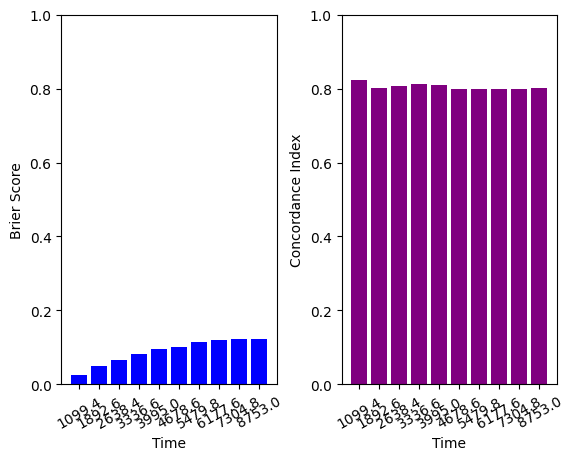

In [106]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

### Breast Cancer

In [35]:
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_breast_cancer()
data_y

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

In [7]:
data_x

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221344_at,X221634_at,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er,grade,size
0,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,9.623518,9.814798,10.016732,7.847383,...,6.313081,7.842097,10.132635,10.926365,6.477749,5.991885,57.0,negative,poorly differentiated,3.0
1,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,10.604577,10.704329,10.161838,8.744875,...,5.126765,8.780328,10.213467,9.555092,4.968050,7.051130,57.0,positive,poorly differentiated,3.0
2,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,9.384927,10.161654,10.032721,8.125487,...,6.936022,7.855649,10.164514,9.308048,4.283777,6.828986,48.0,negative,poorly differentiated,2.5
3,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,8.400839,8.670721,10.727427,8.650810,...,6.787297,6.678375,10.660092,10.208241,5.713404,6.927251,42.0,positive,poorly differentiated,1.8
4,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,7.741092,8.642018,9.556686,8.478862,...,7.312287,7.358556,11.570330,10.931843,5.817265,6.655448,46.0,positive,intermediate,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,12.018292,8.323876,11.955274,10.740020,11.150428,10.650873,8.787549,9.747182,10.176306,9.240307,...,6.354728,9.240358,10.074577,9.604668,6.889179,5.892040,39.0,negative,poorly differentiated,2.2
194,11.711415,10.428482,12.420877,11.145993,11.084685,11.169750,10.870530,11.128882,9.573702,9.287522,...,6.481257,7.645481,11.289674,11.067820,5.393927,6.421038,46.0,negative,poorly differentiated,3.2
195,11.939616,9.615587,11.962812,10.463171,11.514539,11.487394,10.443569,11.104227,9.051649,7.279063,...,6.750251,7.642915,11.490971,7.743568,5.922925,6.979894,47.0,positive,well differentiated,2.5
196,11.848449,10.528911,11.318453,8.609631,13.719035,12.909814,7.525994,8.255546,9.788903,7.343499,...,7.134177,7.536181,11.092211,9.298178,7.278383,7.195797,43.0,positive,intermediate,1.2


In [30]:
#nan values
data_x.isnull().sum()

X200726_at      0
X200965_s_at    0
X201068_s_at    0
X201091_s_at    0
X201288_at      0
               ..
X221928_at      0
age             0
er              0
grade           0
size            0
Length: 80, dtype: int64

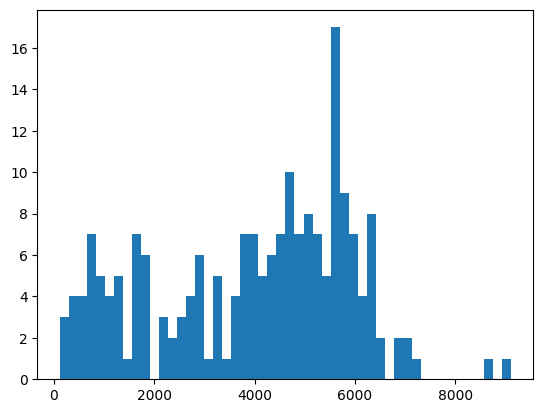

In [31]:
import matplotlib.pyplot as plt
T = data_y["t.tdm"]
E = data_y["e.tdm"]
plt.hist(T, bins = 50) 
plt.show()

#### Cox - Cox L1

<Axes: xlabel='timeline'>

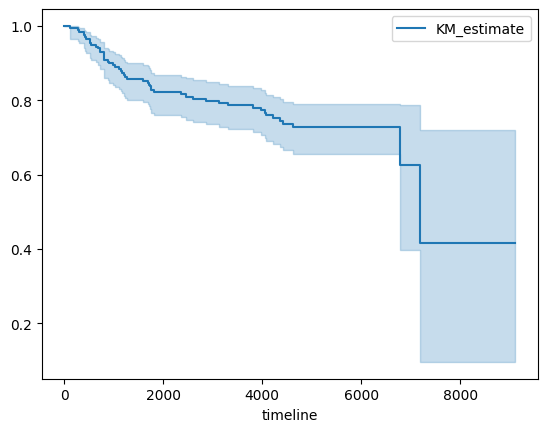

In [5]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations = data_y['t.tdm'], event_observed = data_y['e.tdm'])
kmf.plot_survival_function()

<Axes: xlabel='timeline'>

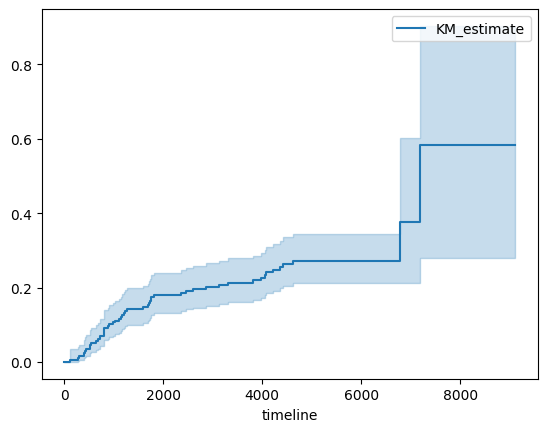

In [10]:
kmf.plot_cumulative_density()

L'étape suivante consiste à estimer la durée médiane de survie et les intervalles de confiance à 95 %. 
Ici, la durée médiane de survie est de 7185 jours, ce qui indique que 50 % de l’échantillon vit 7185 jours et que 50 % décède pendant cette période. La limite inférieure de l'IC à 95 % est de 6777 jours.

In [12]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

7185.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  6777.0                     inf


In [36]:
data_cat = data_x[['er','grade']]
data_cat = pd.get_dummies(data_cat, drop_first=True)
data_num = data_x.drop(columns=['er','grade'])
data_y = pd.DataFrame(data_y, columns=["t.tdm", "e.tdm"])
data = pd.concat([data_cat, data_num,data_y], axis=1)
data

,er_positive,grade_intermediate,grade_poorly differentiated,grade_unkown,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,...,X221344_at,X221634_at,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,size,t.tdm,e.tdm
0,False,False,True,False,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,...,6.313081,7.842097,10.132635,10.926365,6.477749,5.991885,57.0,3.0,723.0,True
1,True,False,True,False,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,...,5.126765,8.780328,10.213467,9.555092,4.968050,7.051130,57.0,3.0,6591.0,False
2,False,False,True,False,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,...,6.936022,7.855649,10.164514,9.308048,4.283777,6.828986,48.0,2.5,524.0,True
3,True,False,True,False,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,...,6.787297,6.678375,10.660092,10.208241,5.713404,6.927251,42.0,1.8,6255.0,False
4,True,True,False,False,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,...,7.312287,7.358556,11.570330,10.931843,5.817265,6.655448,46.0,3.0,3822.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,False,False,True,False,12.018292,8.323876,11.955274,10.740020,11.150428,10.650873,...,6.354728,9.240358,10.074577,9.604668,6.889179,5.892040,39.0,2.2,5673.0,False
194,False,False,True,False,11.711415,10.428482,12.420877,11.145993,11.084685,11.169750,...,6.481257,7.645481,11.289674,11.067820,5.393927,6.421038,46.0,3.2,404.0,True
195,True,False,False,False,11.939616,9.615587,11.962812,10.463171,11.514539,11.487394,...,6.750251,7.642915,11.490971,7.743568,5.922925,6.979894,47.0,2.5,2225.0,False
196,True,True,False,False,11.848449,10.528911,11.318453,8.609631,13.719035,12.909814,...,7.134177,7.536181,11.092211,9.298178,7.278383,7.195797,43.0,1.2,2722.0,False


In [19]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(data, duration_col='t.tdm', event_col='e.tdm')

cph.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 198 total observations, 147 right-censored observations>
             duration col = 't.tdm'
                event col = 'e.tdm'
      baseline estimation = breslow
   number of observations = 198
number of events observed = 51
   partial log-likelihood = -143.67
         time fit was run = 2024-04-17 08:35:54 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
er_positive                  -2.43      0.09      1.87           -6.09            1.23                0.00                3.41
grade_intermediate            4.93    138.70      2.43            0.17            9.70                1.18            16259.55
grade_poorly differentiated   3.36     28.86      2.25           -1.05            7.78                0.35             2384.79
grade_unkown                -16.41      0.00   2888.24        -5677.27         5644.44                0.00                 inf
X200726_at                   -4.03      0.02      2.56           -9.05            0.98                0.00                2.67
X200965_s_at                  0.70      2.02      0.75           -0.76            2.17                0.47                8.72
X201068_s_at                 -3.84      0.02      2.18           -8.11            0.42                0.00                1.53
X201091_s_at                 -2.75      0.06      1.60           -5.88            0.37                0.00                1.45
X201288_at                    0.80      2.23      1.79           -2.70            4.31                0.07               74.39
X201368_at                    0.76      2.13      1.22           -1.64            3.16                0.19               23.47
X201663_s_at                  3.69     40.14      2.29           -0.80            8.18                0.45             3568.47
X201664_at                   -0.36      0.70      2.57           -5.41            4.68                0.00              108.21
X202239_at                   -3.86      0.02      1.68           -7.16           -0.57                0.00                0.57
X202240_at                    3.43     30.85      1.26            0.95            5.90                2.60              366.57
X202418_at                    3.96     52.55      1.88            0.28            7.65                1.32             2090.63
X202687_s_at                 -0.99      0.37      0.89           -2.73            0.75                0.07                2.11
X203306_s_at                 -3.85      0.02      1.26           -6.31           -1.39                0.00                0.25
X203391_at                   -6.10      0.00      1.77           -9.58           -2.63                0.00                0.07
X204014_at                   -0.58      0.56      0.56           -1.67            0.51                0.19                1.67
X204015_s_at                  0.37      1.45      0.93           -1.45            2.19                0.24                8.98
X204073_s_at                  0.21      1.23      0.45           -0.68            1.09                0.51                2.98
X204218_at                   -1.65      0.19      1.68           -4.94            1.65                0.01                5.21
X204540_at                    0.86      2.37      0.36            0.16            1.57                1.17                4.80
X204631_at                   -0.56      0.57      0.64           -1.82            0.71                0.16                2.03
X204740_at                   -0.59      0.56      0.84           -2.24            1.06                0.11                2.89
X204768_s_at                 -0.11      0.90      1.19           -2.43            2.22                0.09                9.22
X204888_s_at                  1.57      4.80      0.91           -0.22            3.36 

<Axes: xlabel='log(HR) (95% CI)'>

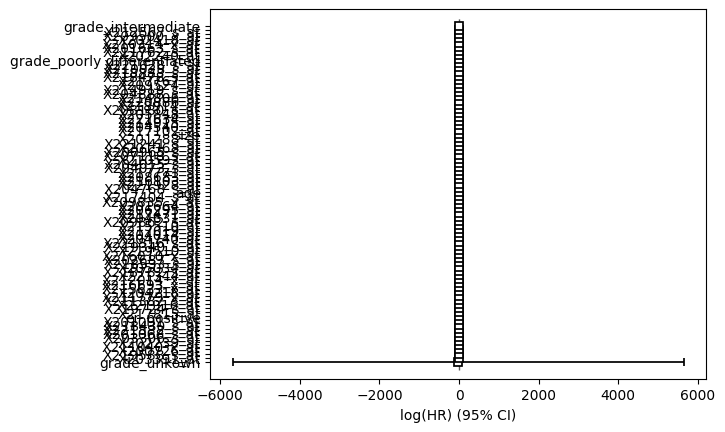

In [20]:
cph.

#### Deep Cox

In [37]:
#extract t.tdm and e.tdm of dataset
y = data[["t.tdm","e.tdm"]]
y["e.tdm"] = y["e.tdm"].astype(int)
#rename columns
y = y.rename(columns={"t.tdm":"time","e.tdm":"event"})
#drop columns in data
data = data.drop(columns=["t.tdm","e.tdm"])

In [39]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data)
#scale the data
data = StandardScaler().fit_transform(data)

#concat4 data and y
data = pd.DataFrame(data, columns=['er_positive', 'grade_intermediate', 'grade_poorly differentiated',
       'grade_unkown', 'X200726_at', 'X200965_s_at', 'X201068_s_at',
       'X201091_s_at', 'X201288_at', 'X201368_at', 'X201663_s_at',
       'X201664_at', 'X202239_at', 'X202240_at', 'X202418_at', 'X202687_s_at',
       'X203306_s_at', 'X203391_at', 'X204014_at', 'X204015_s_at',
       'X204073_s_at', 'X204218_at', 'X204540_at', 'X204631_at', 'X204740_at',
       'X204768_s_at', 'X204888_s_at', 'X205034_at', 'X205848_at',
       'X206295_at', 'X207118_s_at', 'X208180_s_at', 'X208683_at',
       'X209500_x_at', 'X209524_at', 'X209835_x_at', 'X209862_s_at',
       'X210028_s_at', 'X210314_x_at', 'X210593_at', 'X211040_x_at',
       'X211382_s_at', 'X211762_s_at', 'X211779_x_at', 'X212014_x_at',
       'X212567_s_at', 'X214806_at', 'X214915_at', 'X214919_s_at',
       'X215510_at', 'X215633_x_at', 'X216010_x_at', 'X216103_at',
       'X216693_x_at', 'X217019_at', 'X217102_at', 'X217404_s_at',
       'X217471_at', 'X217767_at', 'X217771_at', 'X217815_at', 'X218430_s_at',
       'X218478_s_at', 'X218533_s_at', 'X218782_s_at', 'X218883_s_at',
       'X218914_at', 'X219340_s_at', 'X219510_at', 'X219588_s_at',
       'X219724_s_at', 'X220886_at', 'X221028_s_at', 'X221241_s_at',
       'X221344_at', 'X221634_at', 'X221816_s_at', 'X221882_s_at',
       'X221916_at', 'X221928_at', 'age', 'size'])

array([[-1.44697961, -0.84955231,  1.17709055, ..., -0.89188246,
         1.47227867,  1.01998011],
       [ 0.69109474, -0.84955231,  1.17709055, ..., -0.02237757,
         1.47227867,  1.01998011],
       [-1.44697961, -0.84955231,  1.17709055, ..., -0.20472946,
         0.22294506,  0.39704346],
       ...,
       [ 0.69109474, -0.84955231, -0.84955231, ..., -0.08085306,
         0.08413021,  0.39704346],
       [ 0.69109474,  1.17709055, -0.84955231, ...,  0.09637608,
        -0.47112917, -1.22259183],
       [-1.44697961, -0.84955231,  1.17709055, ...,  0.78461619,
        -1.02638856,  0.39704346]])

In [41]:
data

,er_positive,grade_intermediate,grade_poorly differentiated,grade_unkown,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,...,X221028_s_at,X221241_s_at,X221344_at,X221634_at,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,size
0,-1.446980,-0.849552,1.177091,-0.101015,-2.412172,-1.827564,-0.967844,1.525079,-1.002713,0.224731,...,-0.233251,-1.011080,-0.346288,0.524351,-1.277064,2.343598,0.387715,-0.891882,1.472279,1.019980
1,0.691095,-0.849552,1.177091,-0.101015,1.354149,-1.151923,1.565582,2.580575,0.128485,-1.630347,...,-0.124324,0.581317,-2.103037,1.843017,-1.136506,0.548148,-1.138368,-0.022378,1.472279,1.019980
2,-1.446980,-0.849552,1.177091,-0.101015,-0.307191,-0.312626,1.430299,-1.484399,-0.747487,-0.782777,...,-0.064492,-1.551586,0.576192,0.543398,-1.221629,0.224685,-1.830066,-0.204729,0.222945,0.397043
3,0.691095,-0.849552,1.177091,-0.101015,1.159300,-0.810533,0.252566,-1.616879,1.281765,-0.038667,...,-1.216984,0.259005,0.355953,-1.111237,-0.359876,1.403337,-0.384925,-0.124066,-0.609944,-0.475068
4,0.691095,1.177091,-0.849552,-0.101015,-0.815877,1.172017,-0.588331,-1.950497,-2.543294,-0.712483,...,1.435196,0.069788,1.133382,-0.155256,1.222923,2.350771,-0.279937,-0.347182,-0.054685,1.019980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,-1.446980,-0.849552,1.177091,-0.101015,0.713520,-2.585859,-0.140698,1.150008,-1.523311,-1.815672,...,1.440533,1.351091,-0.284614,2.489578,-1.378019,0.613060,0.803610,-0.973843,-1.026389,0.023281
194,-1.446980,-0.849552,1.177091,-0.101015,-0.164926,-0.087294,1.043575,1.829514,-1.616347,-1.052717,...,2.046052,-0.351635,-0.097245,0.248012,0.734895,2.528811,-0.707869,-0.539602,-0.054685,1.269155
195,0.691095,-0.849552,-0.849552,-0.101015,0.488307,-1.052355,-0.121525,0.686624,-1.008043,-0.585654,...,-0.413363,0.204954,0.301094,0.244404,1.084926,-1.823736,-0.173131,-0.080853,0.084130,0.397043
196,0.691095,1.177091,-0.849552,-0.101015,0.227339,0.031934,-1.760470,-2.415782,2.111629,1.505869,...,0.562999,1.401062,0.869628,0.094393,0.391529,0.211763,1.197037,0.096376,-0.471129,-1.222592


In [43]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(data, y, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 118
Number of validation data points: 40
Number of test data points: 40


In [51]:
y_tr.max()

time     9108.0
event       1.0
dtype: float64

In [46]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

print(x_tr.dtypes)
#print(y_tr)

# Define parameters for tuning the model
param_grid = {'k' : [2, 3],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[100], [100, 100]]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

er_positive                    float64
grade_intermediate             float64
grade_poorly differentiated    float64
grade_unkown                   float64
X200726_at                     float64
                                ...   
X221882_s_at                   float64
X221916_at                     float64
X221928_at                     float64
age                            float64
size                           float64
Length: 82, dtype: object


 56%|█████▌    | 28/50 [00:00<00:00, 76.70it/s]


AssertionError: Times must be within the range of event times.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

In [ ]:
from autograd import numpy as anp
n d = x.shape
soft_abs = lambda x, a : 1 / a * (anp.logaddexp(0, -a * x) + anp.loggadexp(0, a * x))
lambda beta, a : n * (penalizer * (L1_ratio * soft_abs(beta, a)) + 0.5 * (1 - L1_ratio) * (beta^2)).sum()

<a id="rsf"></a>
## 6. Random Survival Forests (RSF)

<b>RSF</b> [4] is an extension of Random Forests to the survival settings where risk scores are computed by creating Nelson-Aalen estimators in the splits induced by the Random Forest.

We observe that performance of the Random Survival Forest model, especially in terms of calibration is strongly influenced by the choice for the hyperparameters for the number of features considered at each split and the minimum number of data samples to continue growing a tree. We thus advise carefully tuning these hyper-parameters while benchmarking RSF.

*For full details on Random Survival Forests (RSF), please refer to the following paper*:

[4] [Hemant Ishwaran et al. Random survival forests. The annals of applied statistics, 2(3):841–860, 2008.](https://arxiv.org/abs/0811.1645)

<a id="fitrsf"></a>
### 6.1. Fit RSF Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'n_estimators' : [100, 300],
              'max_depth' : [3, 5],
              'max_features' : ['sqrt', 'log2']
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('rsf', random_seed=8, n_estimators=param['n_estimators'], max_depth=param['max_depth'], max_features=param['max_features'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evalrsf"></a>
### 6.2. Evaluate RSF Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)